In [1]:
#Import Relevant Keras Deep Learning Modules
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing import image
from keras.models import load_model
from keras import backend as K

#Import Relevant Data Science Modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [162]:
#Training data
path2dat = "C:/Users/alexd/Downloads/ddsm-mammography/"
#train_images = np.load(path2dat + "train_images2.npy")
#train_labels = np.load(path2dat + "train_labels.npy")
validation_images = np.load(path2dat + "Train_Images0.npy")
validation_labels = np.load(path2dat + "Train_Labels0.npy")

In [165]:
x = validation_images[3]
y = validation_labels[3]
del validation_images, validation_labels

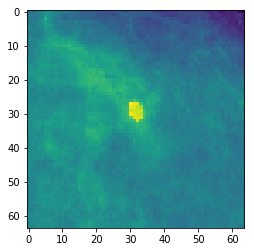

In [166]:
plt.imshow(x[:,:,1])

In [167]:
x1 = np.expand_dims(x,axis=0)

In [168]:
#Load Model
path2model = "C:/Users/alexd/"
model = load_model(path2model + 'Shallower_CNN_Case2.h5')

In [169]:
#Confusion Matrix 
predictions = model.predict(x1,batch_size=5)

1


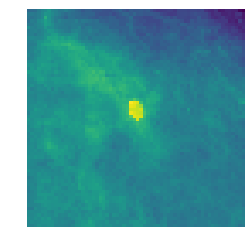

In [170]:
i = 0
plt.imshow(x1[i,:,:,1])
plt.axis('off')
print(y)

In [22]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)
    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [23]:
def generate_pattern(model,layer_name, filter_index, size=64):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]
    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3))
    # Run gradient ascent for 40 steps
    step = 1.
    
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

In [24]:
def plot_feature_map(model,height,width,figscale,layer_name):
    fig, ax = plt.subplots(height,width, 
                           sharex='col', 
                           sharey='row',
                           gridspec_kw = {'wspace':0, 'hspace':0},
                           figsize=(height*figscale,(height*height*figscale)/width))
    #fig.subplots_adjust(wspace=0, hspace=0)
    # axes are in a two-dimensional array, indexed by [row, col]
    for i in range(height):
        for j in range(width):
            ax[i, j].axis('off')
            ax[i, j].set_aspect('equal')  
            filter_img = generate_pattern(model,layer_name, j + i*width,64)
            ax[i, j].imshow(filter_img)

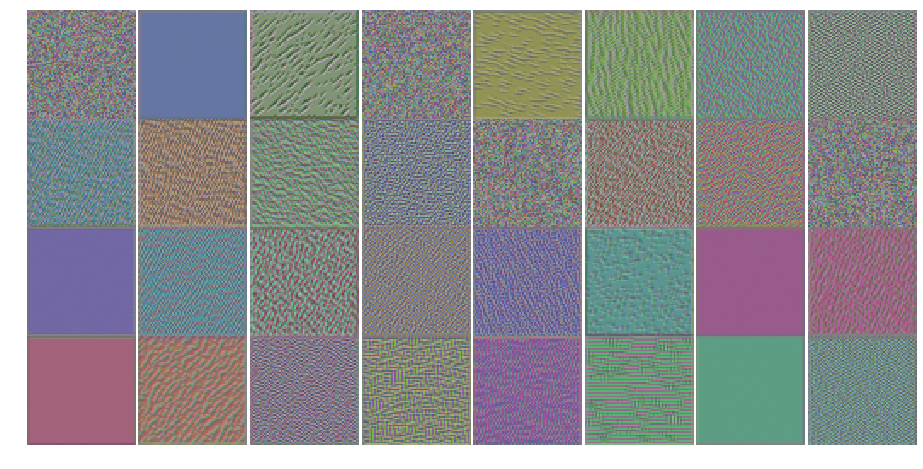

In [25]:
plot_feature_map(model,4,8,4,"conv2d_1")

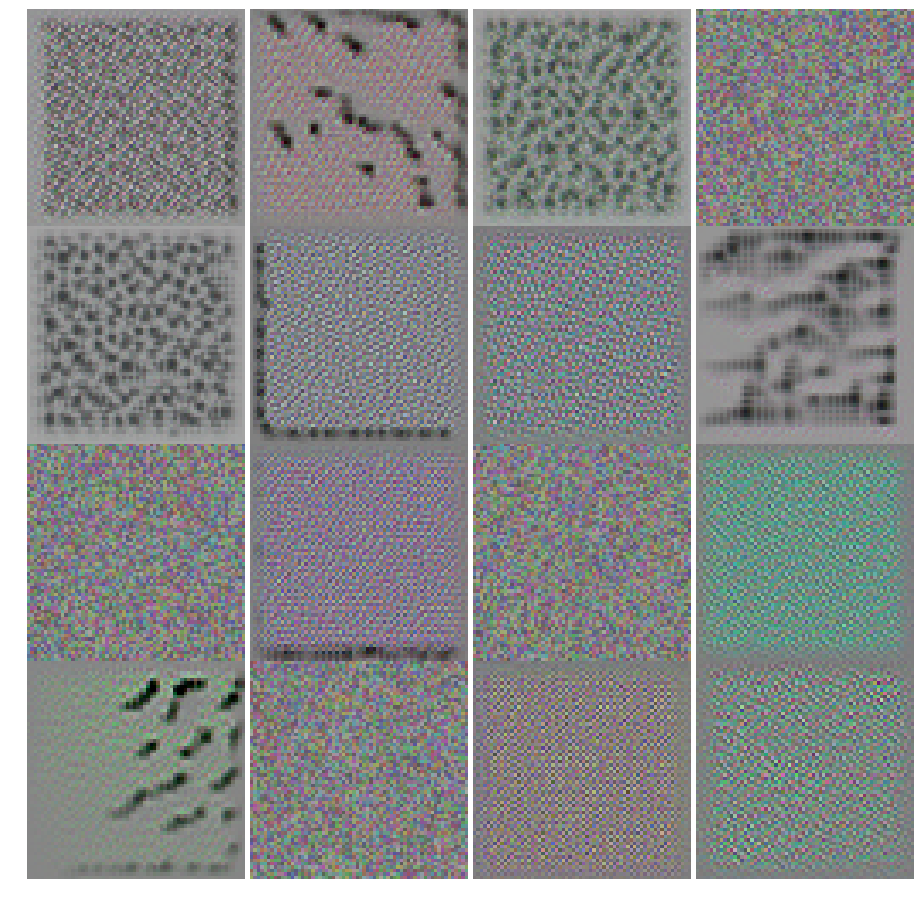

In [26]:
plot_feature_map(model,4,4,4,"conv2d_2")

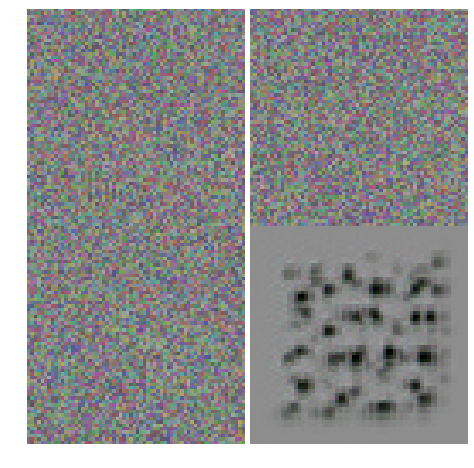

In [27]:
plot_feature_map(model,2,2,4,"conv2d_3")

In [171]:
# There is a lump
#plt.imshow(validation_images[97,:,:,1])
preds = model.predict(x1,batch_size=5)
print(preds)

[[0.9955804]]


In [172]:
np.argmax(preds)

0

1


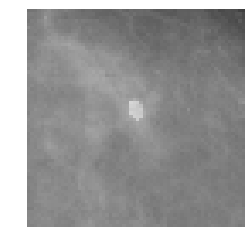

In [173]:
plt.imshow(x1[0,:,:,:])
plt.axis('off')
print(y)

In [174]:
x1.shape

(1, 64, 64, 3)

In [175]:
x.shape

(64, 64, 3)

In [176]:
lump_output = model.output[0]
last_conv_layer = model.get_layer('conv2d_3')

grads = K.gradients(lump_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x1])

for i in range(7):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)

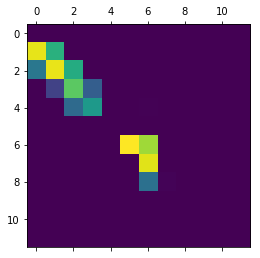

In [177]:
heatmap = np.maximum(heatmap,0)
heatmap/=np.max(heatmap)
plt.matshow(heatmap)

In [178]:
import cv2
heatmap = cv2.resize(heatmap,(x.shape[1],x.shape[0]))
heatmap = np.uint8(255*heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

In [189]:
superimposed_img = heatmap*0.001 + x1[0,:,:,:]

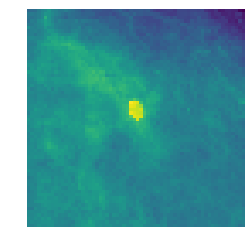

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


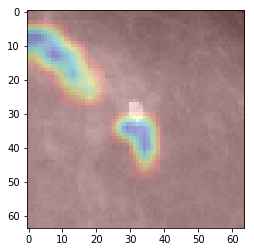

In [190]:
plt.axis('off')
i = 0
plt.imshow(x1[i,:,:,1])
plt.axis('off')
plt.show()
plt.imshow(superimposed_img)
plt.show()